# Applying some basic machine learning to the culled dataset of amino acid distances and antigenic distances


In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import linear_model as sklm
from sklearn import svm
from sklearn import ensemble
from sklearn import grid_search
import plotly.plotly as py
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures


Populating the interactive namespace from numpy and matplotlib


### A function to create new columns containing the full dates of both strains 

In [2]:
def seperate_dates(datfr, col1, col2):
    strain_1_labels = list(datfr[col1])
    strain_2_labels = list(datfr[col2])
    
    strain_1_dates = []
    strain_2_dates = []
    
    for label in strain_1_labels:
        date = int(list(label.split('/'))[-1])
        if date <60:
            date+=2000
        else:
            date+=1900
        strain_1_dates.append(date)
        
    for label2 in strain_2_labels:
        date = int(list(label2.split('/'))[-1])
        if date <60:
            date+=2000
        else:
            date+=1900
        strain_2_dates.append(date)
    
    datfr['strain_1_dates'] = pd.Series(strain_1_dates, index=datfr.index)
    datfr['strain_2_dates'] = pd.Series(strain_2_dates, index=datfr.index)

    

### A function to add a column with strain 1 and 2 clusters
Clusters defined based on the map here: http://www.antigenic-cartography.org/ 

In [3]:
def add_clusters(datfr, date1, date2):

    cluster1 = []
    cluster2 = []

    for date in datfr[date1]:
        if date<1972:
            cluster1.append('HK68')
        elif date < 1975:
                cluster1.append('EN72')
        elif date < 1977:
                cluster1.append('VI75')
        elif date < 1979:
                cluster1.append('BK79')
        elif date < 1987:
                cluster1.append('VI75')
        elif date < 1989:
                cluster1.append('SI87')
        elif date < 1992:
                cluster1.append('BE89')
        elif date < 1995:
                cluster1.append('BE92')
        elif date < 1997:
                cluster1.append('WU95')
        elif date < 2002:
                cluster1.append('SY97')
        else:
                cluster1.append('FU02')
   
    
    for date in datfr[date2]:
        if date<1972:
            cluster2.append('HK68')
        elif date < 1975:
                cluster2.append('EN72')
        elif date < 1977:
                cluster2.append('VI75')
        elif date < 1979:
                cluster2.append('BK79')
        elif date < 1987:
                cluster2.append('VI75')
        elif date < 1989:
                cluster2.append('SI87')
        elif date < 1992:
                cluster2.append('BE89')
        elif date < 1995:
                cluster2.append('BE92')
        elif date < 1997:
                cluster2.append('WU95')
        elif date < 2002:
                cluster2.append('SY97')
        else:
                cluster2.append('FU02')
    
    cluster1 = pd.Series(cluster1)
    cluster2 = pd.Series(cluster2)

    datfr['cluster1'] = pd.Series(cluster1, index=datfr.index)
    datfr['cluster2'] = pd.Series(cluster2, index=datfr.index)

### A function to create a cross validation set
The training set consists of all pairs where neither strain is a member of a particular cluster. 
The test set consists of all pairs where at least one strain is a member of that cluster

In [4]:
def cv(df, cluster1, cluster2):
    cv = [(np.where((df[cluster1] != label) & (df[cluster2] != label))[0], 
                    np.where((df[cluster1] == label) & (df[cluster2] ==label))[0])
               for label in np.unique(df[cluster1])]
    return cv

In [5]:
file = open('35yr-culled-1-20-to-25.csv')
df = pd.read_csv(file)
#df = df.drop(0)
#df = df.drop('Unnamed: 75', axis = 1)
seperate_dates(df, 'AG1', 'AG2')
add_clusters(df, 'strain_1_dates', 'strain_2_dates')
df.shape
print(df.head)

<bound method NDFrame.head of               AG1          AG2     AGDIST  HD  AT131  AT138  AV163  AV272  \
0     BI/15793/68  BI/15793/68   0.000000   0      0      0      0      0   
1     BI/16190/68  BI/16190/68   0.000000   0      0      0      0      0   
2     BI/16398/68  BI/16398/68   0.000000   0      0      0      0      0   
3       BI/908/69    BI/908/69   0.000000   0      0      0      0      0   
4     BI/17938/69  BI/17938/69   0.000000   0      0      0      0      0   
5     BI/21438/71  BI/21438/71   0.000000   0      0      0      0      0   
6     BI/21801/71  BI/21801/71   0.000000   0      0      0      0      0   
7     BI/21793/72  BI/21793/72   0.000000   0      0      0      0      0   
8     BI/23290/72  BI/23290/72   0.000000   0      0      0      0      0   
9     BI/23290/72  BI/23337/72   0.000000   0      0      0      0      0   
10    BI/23337/72  BI/23337/72   0.000000   0      0      0      0      0   
11      BI/552/73    BI/552/73   0.000000   0 

### Checking the distribution of the data
The data are dominated by strains from the early 1990s

(array([   61.,    37.,     0.,    33.,    45.,    38.,    39.,    18.,
           28.,    22.,     0.,     0.,    82.,    81.,    74.,    76.,
            0.,   345.,   113.,   112.,     0.,  1065.,   398.,  1350.,
         2409.,   827.,    71.,    56.,     3.,     1.,     0.,     0.,
            0.,     0.,    16.]),
 array([ 1968.,  1969.,  1970.,  1971.,  1972.,  1973.,  1974.,  1975.,
         1976.,  1977.,  1978.,  1979.,  1980.,  1981.,  1982.,  1983.,
         1984.,  1985.,  1986.,  1987.,  1988.,  1989.,  1990.,  1991.,
         1992.,  1993.,  1994.,  1995.,  1996.,  1997.,  1998.,  1999.,
         2000.,  2001.,  2002.,  2003.]),
 <a list of 35 Patch objects>)

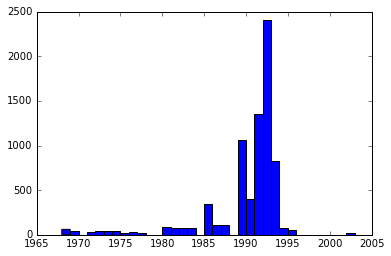

In [6]:
plt.hist(df['strain_1_dates'], bins = 35)

(array([    6.,     9.,     0.,    13.,    27.,    36.,    45.,    33.,
           82.,    16.,     0.,     0.,    11.,    12.,    13.,    11.,
            0.,    21.,     9.,    10.,     0.,   155.,    87.,   464.,
         2173.,  2351.,   508.,   979.,   213.,   100.,     0.,     0.,
            0.,     0.,    16.]),
 array([ 1968.,  1969.,  1970.,  1971.,  1972.,  1973.,  1974.,  1975.,
         1976.,  1977.,  1978.,  1979.,  1980.,  1981.,  1982.,  1983.,
         1984.,  1985.,  1986.,  1987.,  1988.,  1989.,  1990.,  1991.,
         1992.,  1993.,  1994.,  1995.,  1996.,  1997.,  1998.,  1999.,
         2000.,  2001.,  2002.,  2003.]),
 <a list of 35 Patch objects>)

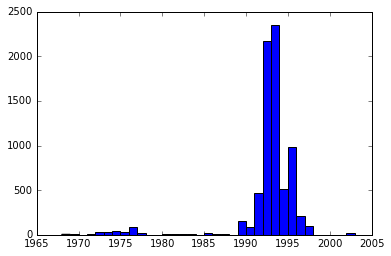

In [7]:
plt.hist(df['strain_2_dates'], bins = 35)

#### Making x and y sets as well as a train/test split 


In [8]:
X = df.drop(['AG1', 'AG2', 'AGDIST', 'HD', 
                   'strain_1_dates', 'strain_2_dates', 'cluster1', 'cluster2'], axis = 1)
y = df['AGDIST']

train = df.loc[((df['strain_1_dates']<=1994)& (df['strain_2_dates'] <=1994))]

test = df.loc[((df['strain_1_dates']>1994) |(df['strain_2_dates'] >1994))]

xtrain = train.drop(['AG1', 'AG2', 'AGDIST', 'HD', 
                       'strain_1_dates', 'strain_2_dates', 'cluster1', 'cluster2'], axis = 1)
ytrain = train['AGDIST']

xtest = test.drop(['AG1', 'AG2', 'AGDIST', 'HD', 
                       'strain_1_dates', 'strain_2_dates', 'cluster1', 'cluster2'], axis = 1)
ytest = test['AGDIST']

merged = pd.concat([train, test])
assert max(merged.duplicated())==0
assert not pd.isnull(merged).values.any()

In [9]:
#Creating a dataset with interaction terms
iX = df.drop(['AG1', 'AG2', 'AGDIST', 'HD', 
                   'strain_1_dates', 'strain_2_dates', 'cluster1', 'cluster2'], axis = 1)
for col1 in X.columns:
    for col2 in X.columns:
        if col1<col2:
            if max(iX[col1]*iX[col2]) >0:
                iX['%s:%s' %(col1, col2)] = (iX[col1]*iX[col2])
    

In [10]:
ixtrain = iX.loc[((df['strain_1_dates']<=1994)& (df['strain_2_dates'] <=1994))]
ixtest = iX.loc[((df['strain_1_dates']>1994) |(df['strain_2_dates'] >1994))]


In [11]:
hdtest = np.array(test['HD']).reshape(-1,1)
hdtrain = train['HD']
hdtrain=np.array(hdtrain).reshape(-1,1)
print(hdtrain.shape)

hdxtrain = train.drop(['AG1', 'AG2', 'AGDIST', 
                       'strain_1_dates', 'strain_2_dates', 'cluster1', 'cluster2'], axis = 1)
hdxtrain['HD'] = train['HD']
hdxtest = test.drop(['AG1', 'AG2', 'AGDIST',
                     'strain_1_dates', 'strain_2_dates', 'cluster1', 'cluster2'], axis = 1)


(6092, 1)


In [12]:
cvlist = cv(train, 'cluster1', 'cluster2')

In [13]:
for tple in cvlist:
    assert set(tple[0]).isdisjoint(tple[1])

### Checking that the training and test data are disjoint
Looks good

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  979.,
         213.,  100.,    0.,    0.,    0.,    0.,   16.]),
 array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
        1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
        1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
        1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]),
 <a list of 43 Patch objects>)

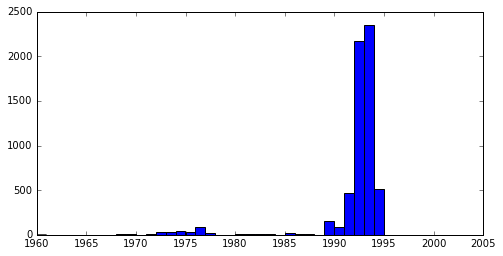

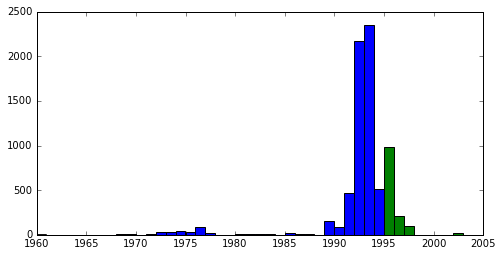

In [14]:
fig_size = [8, 4]
plt.rcParams["figure.figsize"] = fig_size
 
plt.hist((train[['strain_1_dates', 'strain_2_dates']].max(axis=1)), bins=range(1960,2004))
figure(2)
plt.hist((train[['strain_1_dates', 'strain_2_dates']].max(axis=1)), bins=range(1960,2004))
plt.hist((test[['strain_1_dates', 'strain_2_dates']].max(axis=1)), bins=range(1960,2004), color = 'g')


#### Here's a function to plot the coefficients of a linear model

In [30]:
def coefplot(coefs, omitsmall = True, interaction = False):
    fig_size = [20, 10]
    plt.rcParams["figure.figsize"] = fig_size
    if interaction:
        params = pd.DataFrame(data = coefs, index = ixtrain.columns)
    else:
        params = pd.DataFrame(data = coefs, index = xtrain.columns)
    if omitsmall:
        params = params.loc[(params[0]<-0.01)|(params[0]>0.01)]
    params = params.sort_values(0)
    fig, ax = plt.subplots()
    x = range(len(params.index))
    ax.scatter(x, list(params[0]), color="g", s=10)
    xticks(x, x)
    ax.set_xlim([-1, len(params)])
    
    ax.set_xticklabels(["\n".join(list(name)) for name in params.index],
                       fontsize=10)

### Let's have a look at how far apart in years the antigenic distance comparisons we have are


(array([ 1435.,  1942.,  1207.,  1018.,   615.,   254.,   257.,   205.,
          153.,    91.,    92.,    65.,    57.,     8.,     1.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

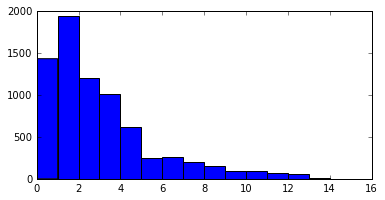

In [16]:
fig_size = [6, 3]
plt.rcParams["figure.figsize"] = fig_size

plt.hist(df['strain_2_dates']-df['strain_1_dates'], bins = range(16))

### What is the distribution of antigenic distances?


(array([ 312.,  407.,  471.,  432.,  347.,  339.,  248.,  221.,  242.,
         279.,  301.,  301.,  305.,  364.,  433.,  451.,  424.,  370.,
         305.,  232.,  176.,  123.,   94.,   70.,   65.,   35.,   23.,
          10.,   10.,    2.,    4.,    4.]),
 array([  0.   ,   0.479,   0.958,   1.438,   1.917,   2.396,   2.875,
          3.354,   3.834,   4.313,   4.792,   5.271,   5.75 ,   6.23 ,
          6.709,   7.188,   7.667,   8.146,   8.626,   9.105,   9.584,
         10.063,  10.542,  11.022,  11.501,  11.98 ,  12.459,  12.938,
         13.418,  13.897,  14.376,  14.855,  15.335]),
 <a list of 32 Patch objects>)

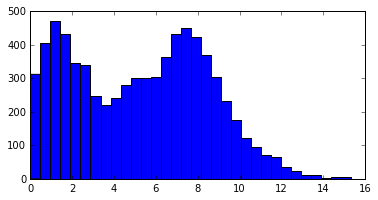

In [17]:
fig_size = [6, 3]
plt.rcParams["figure.figsize"] = fig_size

plt.hist(df['AGDIST'], bins = 32)

In [18]:
def errorplot(clf, xtst):
    fig_size = [15, 6]
    plt.rcParams["figure.figsize"] = fig_size

    errors = ytest.to_frame()
    errors['ytest'] = ytest
    errors['predicted'] = clf.predict(xtst)
    errors['error'] = errors['ytest']-errors['predicted']
    errors['date'] = test['strain_2_dates']
    errors = errors.sort_values('error')
    plt.figure(1)
    plt.scatter(range(len(ytest)), errors['error'])
    plt.xlim(0, len(ytest)+1)
    
    plt.figure(2)
    plt.scatter(range(len(ytest)), errors['ytest'], color = 'g')
    plt.scatter(range(len(ytest)), errors['predicted'])
    plt.scatter(range(len(ytest)), errors['error'], color = 'r')
    
    plt.figure(3)
    errors = errors.sort_values('date')
    errors['jittered_dates'] = errors['date'] + np.random.uniform(-2, 2, len(test))
    plt.scatter(errors['jittered_dates'], errors['ytest'], color = 'g')
    plt.scatter(errors['jittered_dates'], errors['predicted'], color = 'b')
    plt.scatter(errors['jittered_dates'], errors['error'], color = 'r')
    
    plt.figure(4)
    plt.hist(errors['error'])

### Now we try fitting various ml models

In [19]:
clf=sklm.LinearRegression()
clf.fit(xtrain, ytrain)
score=clf.score(xtest, ytest)
print(score)

-4.84969453647e+24


/Users/beth/.virtualenvs/zoopy3/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



Oh dear, that didn't work very well. Let's have a look at the coefficients.

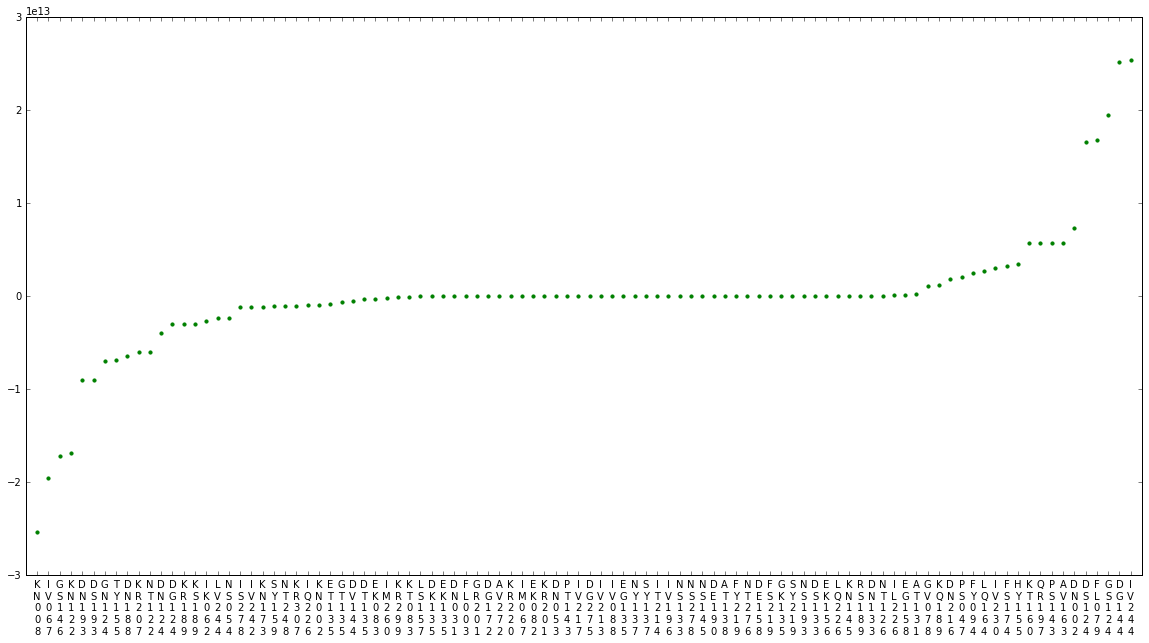

In [20]:
coefplot(clf.coef_)

It looks like quite a few of the coefficients are quite strongly negative, and most of them are zero

### As a baseline, how well can we do with just Hamming Distances?

In [21]:
hdclf=sklm.LinearRegression()
hdclf.fit(hdtrain, ytrain)
score=hdclf.score(hdtest, ytest)
print(score)

0.538896864456


This is better than Oskar's model.
Anything below an r^2 of 0.55 is worse than just counting the number of mutations

(0, 17)

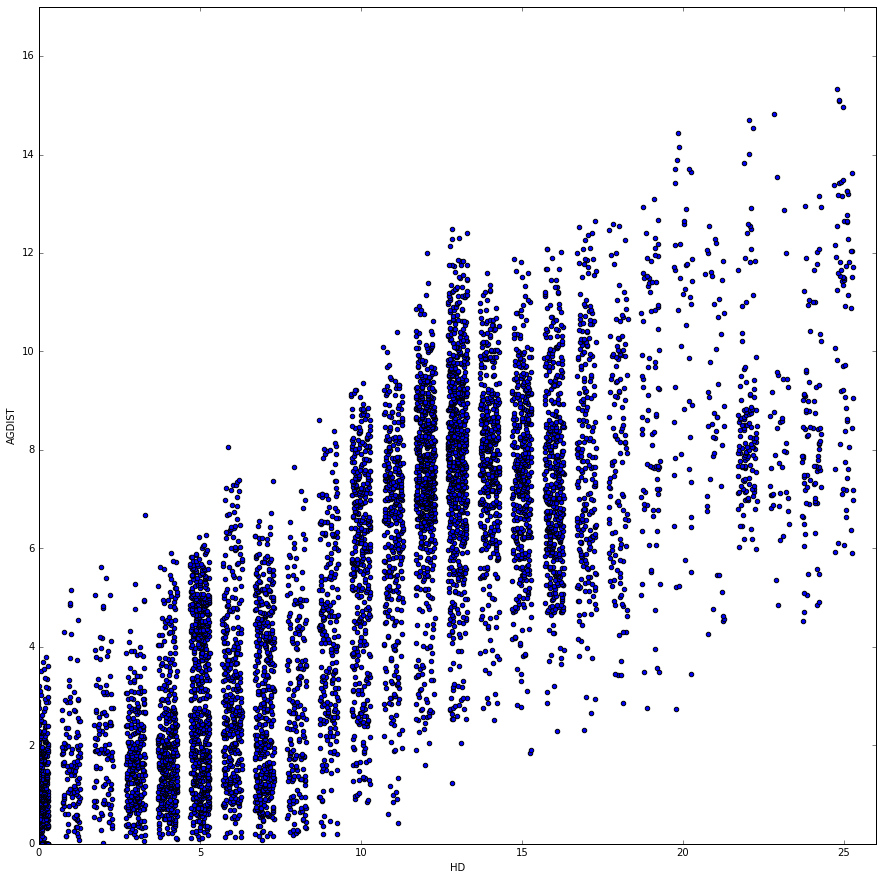

In [22]:
fig_size = [15, 15]
plt.rcParams["figure.figsize"] = fig_size
jitteredHD = df['HD'] + np.random.uniform(-0.3, 0.3, len(df))
plt.xlabel('HD')
plt.ylabel('AGDIST')
plt.scatter(jitteredHD, df['AGDIST'])
plt.xlim(0,26)
plt.ylim(0,17)

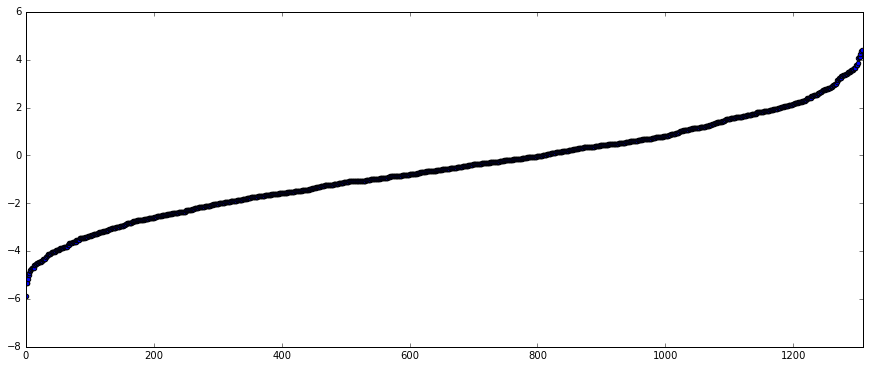

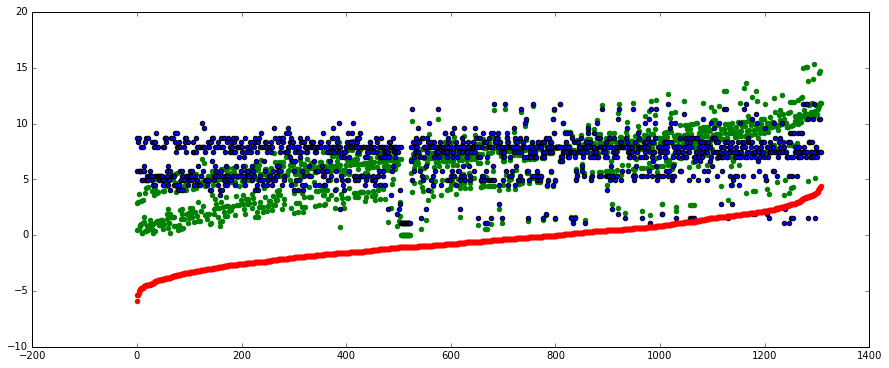

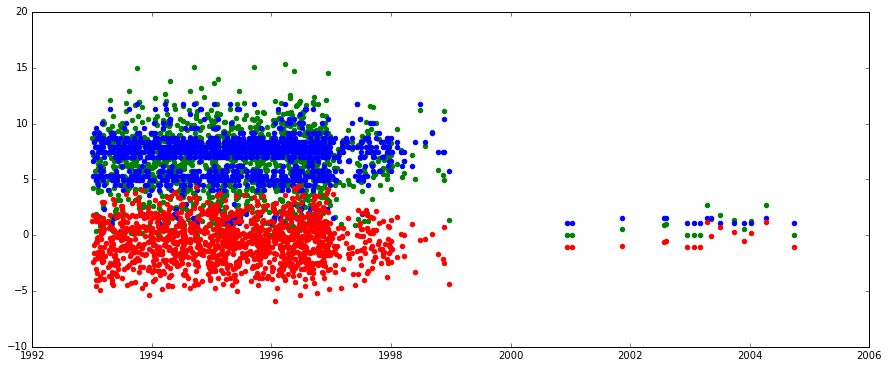

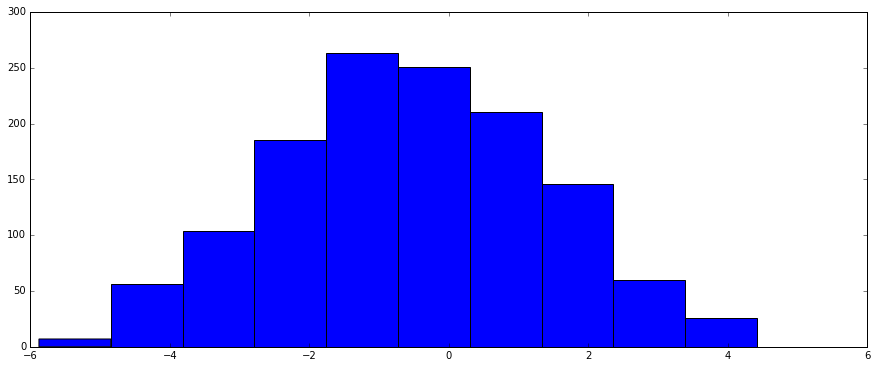

In [23]:
errorplot(hdclf, hdtest)

### Now let's try a regularized linear regression

In [24]:
scores1 = []
for a in [0.01, 0.1, 1, 10 , 100, 1000, 1500, 2000, 3000]:
    clf1 = sklm.Ridge(alpha = a)
    clf1.fit(xtrain, ytrain)
    scores1.append(clf1.score(xtest, ytest))
print(scores1)

[0.58732485521787181, 0.58789661814330918, 0.59303620992188688, 0.61845454936290101, 0.650201675768458, 0.63240098440489578, 0.61783108806370868, 0.60286887322182636, 0.57225890685328151]


In [25]:
scores1 = []
scores2 = []
for a in [5, 10, 20, 40, 80, 100, 200, 300, 400]:
    clf1 = sklm.Ridge(alpha = a)
    clf1.fit(xtrain, ytrain)
    scores1.append(clf1.score(xtest, ytest))
    scores2.append(clf1.score(xtrain,ytrain))
print(scores1)

print('The fit on the training data is')
print(scores2)


[0.60804480365827063, 0.61845454936290101, 0.62974337506406997, 0.64033185433305451, 0.64842435022813072, 0.650201675768458, 0.65244746732256642, 0.65116368822519322, 0.6489430812752176]
The fit on the training data is
[0.91200778930460202, 0.91155376382112074, 0.91068565833064374, 0.90901287486711546, 0.90580462345300761, 0.90425964540147963, 0.89705838217032818, 0.89056647846399828, 0.88459704380161841]


In [26]:
clf = sklm.Ridge(alpha = 300)
clf.fit(xtrain,ytrain)
clf.score(xtest, ytest)

0.65116368822519322

#### Let's see what the errors look like

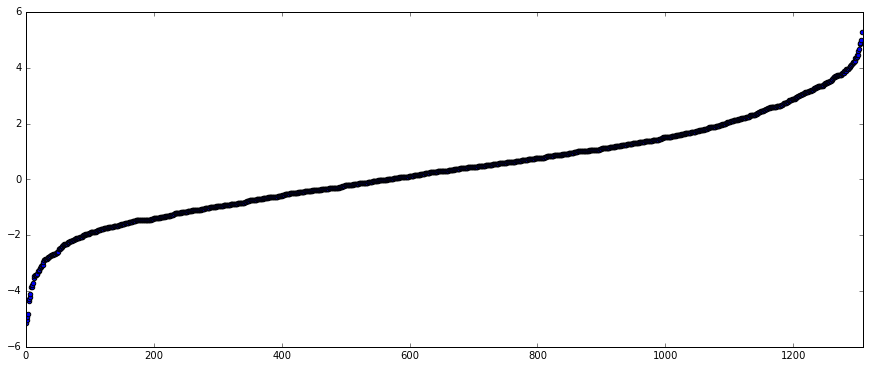

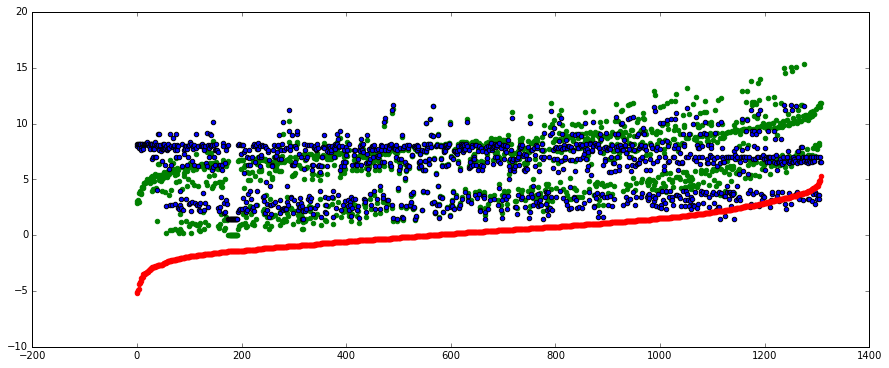

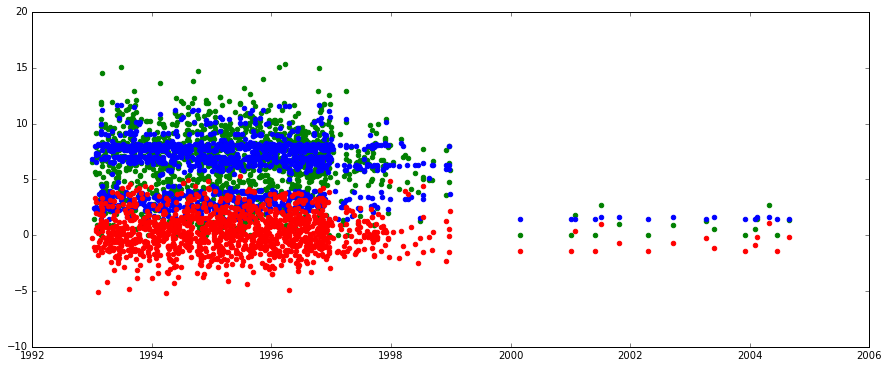

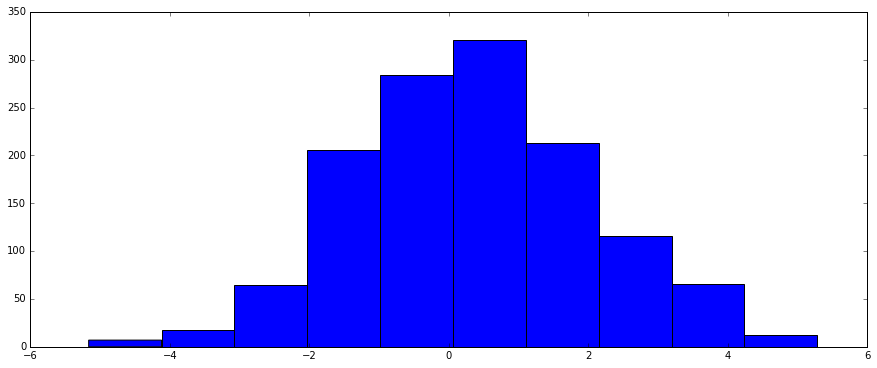

In [27]:
errorplot(clf, xtest)

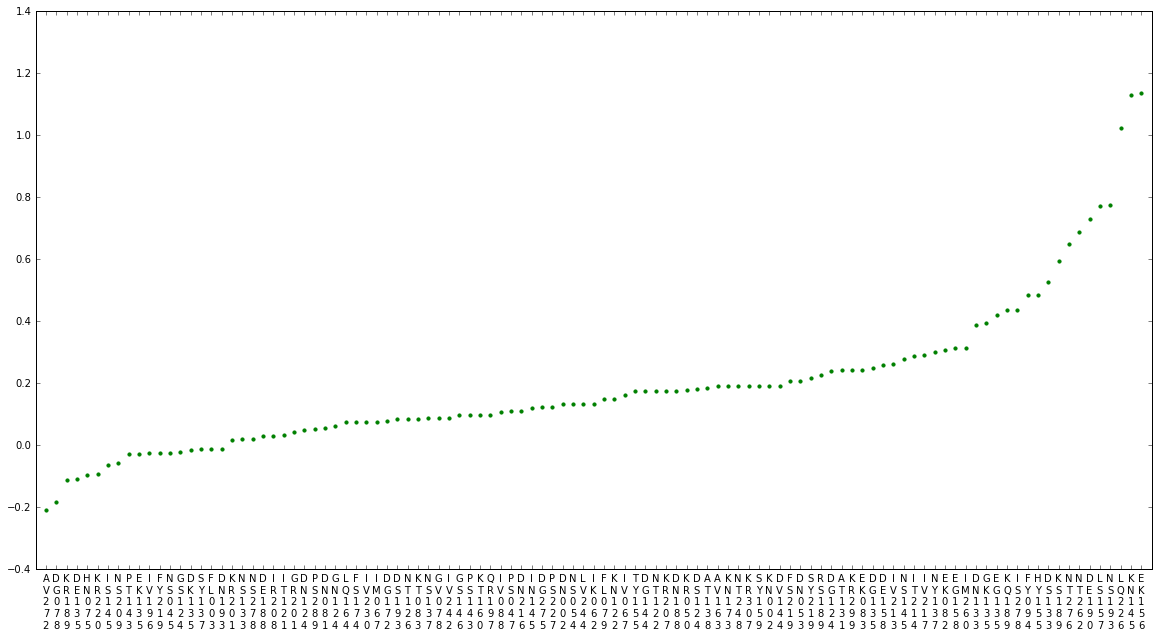

In [31]:
coefplot(clf.coef_)

### What happens if we include hamming distance in the model?

In [29]:

scores1 = []
for a in [5, 10, 20, 40, 80, 100, 200, 300, 400]:
    clf1 = sklm.Ridge(alpha = a)
    clf1.fit(hdxtrain, ytrain)
    scores1.append(clf1.score(hdxtest, ytest))
print(scores1)

[0.60693962180528782, 0.61856129007013916, 0.62991981627591964, 0.63935973171697114, 0.6454637040026161, 0.64656053313406026, 0.64703661093608111, 0.64515692650493284, 0.6428004907342264]


Seems like accuracy is slightly worse but basically the same. The errors look pretty similar, maybe a tiny bit better around the extremes

### Let's try a lasso penalised regression, and force the coefficients to be positive

In [30]:
scores =[]
for a in [0.001, 0.005, 0.008, 0.009, 0.01, 0.015, 0.05, 0.1, 1]:
    clf1 = sklm.Lasso(alpha = a, positive=True)
    clf1.fit(xtrain, ytrain)
    scores.append(clf1.score(xtest, ytest))
print(scores)


[0.58672195635350044, 0.58548399159450715, 0.59143179954570724, 0.59297721772911949, 0.59440174549624158, 0.60085168308897896, 0.58844608212208083, 0.59446800361201424, 0.021393838716362357]


In [31]:
clf = sklm.Lasso(alpha = 0.015, positive=True)
clf.fit(xtrain, ytrain)
clf.score(xtest, ytest)

0.60085168308897896

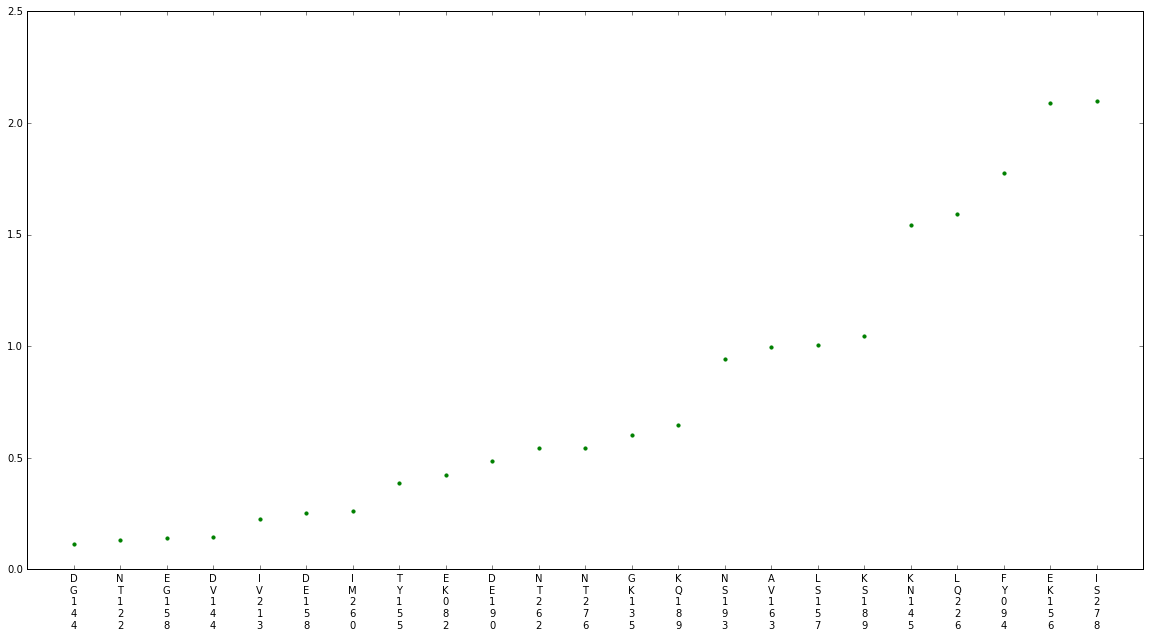

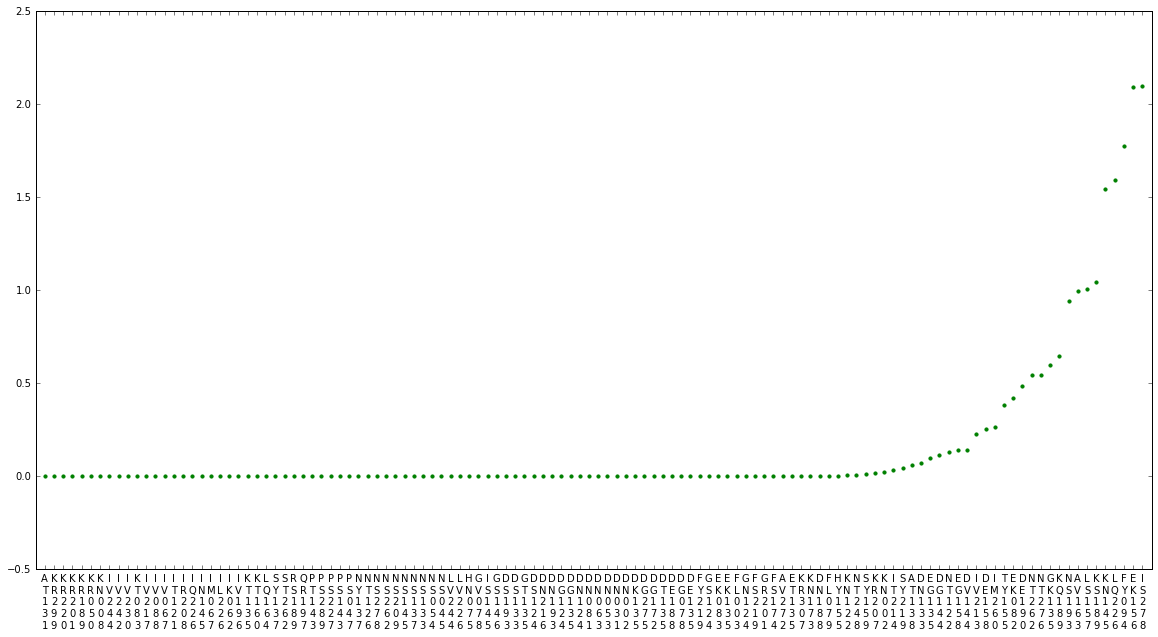

In [32]:
coefplot(clf.coef_, True)
plt.figure(2)
coefplot(clf.coef_, False)

### Let's try including the interaction terms in a lasso model

In [33]:
iscores =[]
for a in [0.001, 0.005, 0.008, 0.009, 0.01, 0.015, 0.05, 0.1, 1]:
    iclf = sklm.Lasso(alpha = a, positive=True)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

[0.50379204352790663, 0.5223909783298295, 0.55012194613887511, 0.55836353274493611, 0.56553209039451713, 0.59128728015351584, 0.58574342894024445, 0.59476586906619267, 0.021393838716362357]


In [34]:
iscores =[]
for a in [0.01, 0.015, 0.05, 0.1, 0.2, 0.3]:
    iclf = sklm.Lasso(alpha = a)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

[0.56742746436043445, 0.59054211215314756, 0.58574365987370225, 0.59476598363781474, 0.57155085256642968, 0.49854887972814238]


In [36]:
iclf = sklm.Lasso(alpha = 0.1 )
iclf.fit(ixtrain, ytrain)
iclf.score(ixtest, ytest)

0.59476598363781474

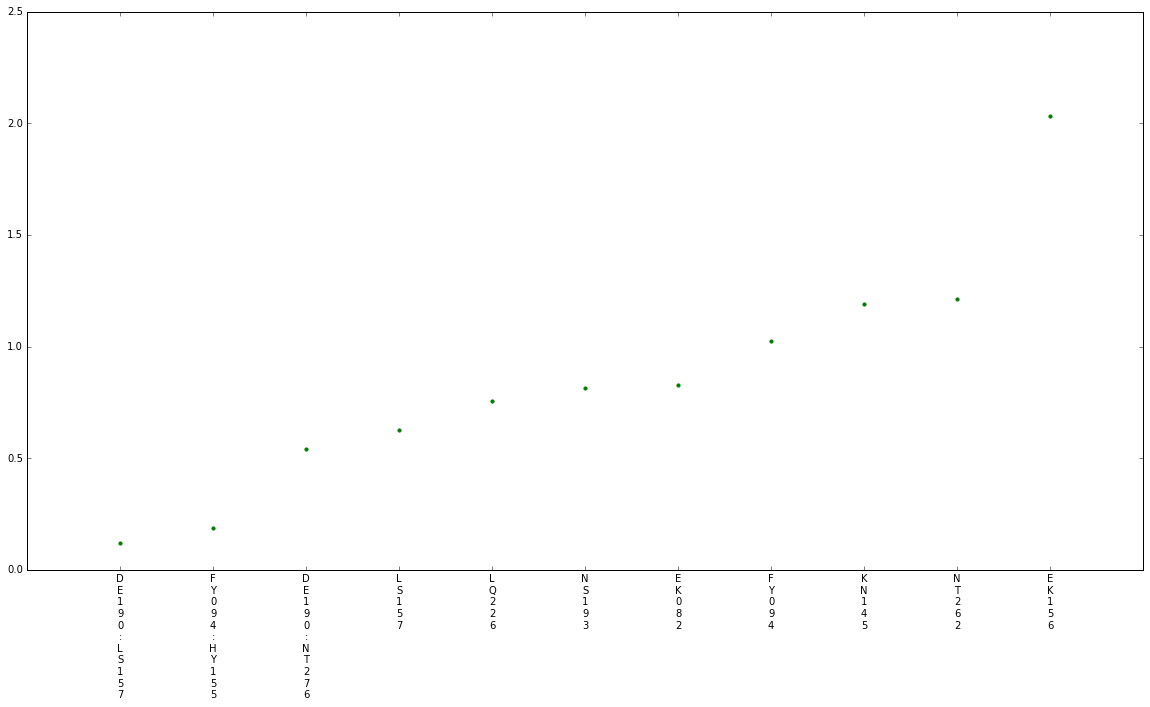

In [37]:
coefplot(iclf.coef_, True, True)
plt.figure(2)

In [39]:
def getcoefs(coefs, omitsmall = True):
    cfs = pd.DataFrame(data = coefs, index = ixtrain.columns)
    if omitsmall:
        cfs = cfs.loc[(cfs[0]<-0.1)|(cfs[0]>0.1)]
    cfs = cfs.sort_values(0)
    return cfs


The distances for the 3 interaction terms (from right to left) are 52.3, 26.8 and 14.9. 

52.3 is too far apart to be a plausible distance, but 26.8 and 14.9 seem to be valid interaction terms

Let's find out whether DE190 and NT276 ever occur apart

In [59]:
print(sum(ixtrain['NT276']))
print(sum(ixtrain['DE190']))
print(sum(ixtrain['NT276'] & (ixtrain['DE190'])))
print(sum(ixtrain['NT276'] & ~(ixtrain['DE190'])))
print(sum(~(ixtrain['NT276']) & (ixtrain['DE190'])))

2105
2382
1945
160
437


In [41]:
getcoefs(iclf.coef_)

,0
DE190:LS157,0.121392
FY094:HY155,0.186817
DE190:NT276,0.540139
LS157,0.627409
LQ226,0.756379
NS193,0.814886
EK082,0.827604
FY094,1.025167
KN145,1.191510
NT262,1.212920


### Let's try using interaction terms with a ridge model

In [32]:
iscores =[]
for a in [0.01, 0.1, 1, 10, 100, 1000]:
    iclf = sklm.Ridge(alpha = a)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

[-1.5502426424747624, 0.1033809312441092, 0.43133870380974859, 0.50293940850246055, 0.50332728567881213, 0.54730101603221426]


In [33]:
iscores =[]
for a in [100, 1000, 2000, 5000, 10000]:
    iclf = sklm.Ridge(alpha = a)
    iclf.fit(ixtrain, ytrain)
    iscores.append(iclf.score(ixtest, ytest))
print(iscores)

[0.50332728567881213, 0.54730101603221426, 0.5645280458107369, 0.57543823617344469, 0.56313095287714687]


In [ ]:
iclf = sklm.Lasso(alpha = 0.1 )
iclf.fit(ixtrain, ytrain)
iclf.score(ixtest, ytest)

### Let's try using support vector machines!

In [150]:
clf2 = svm.SVR()
clf2.fit(xtrain, ytrain)
svmscore=clf2.score(xtest, ytest)
print(svmscore)

0.66921345878


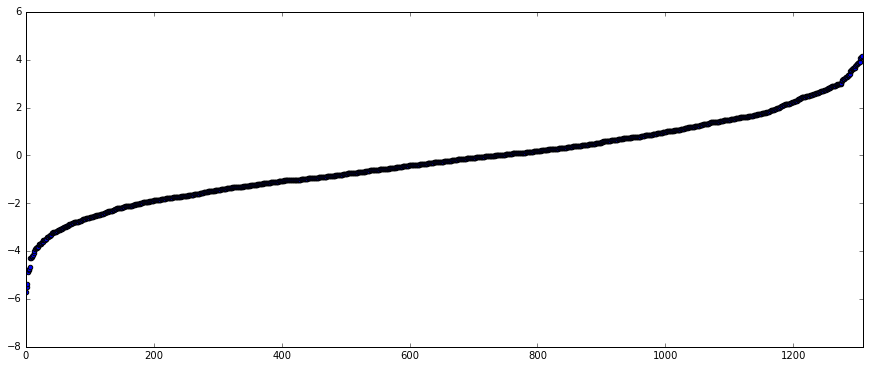

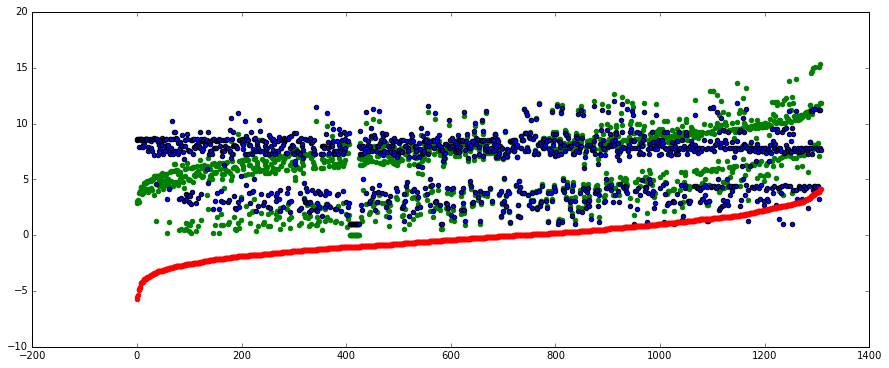

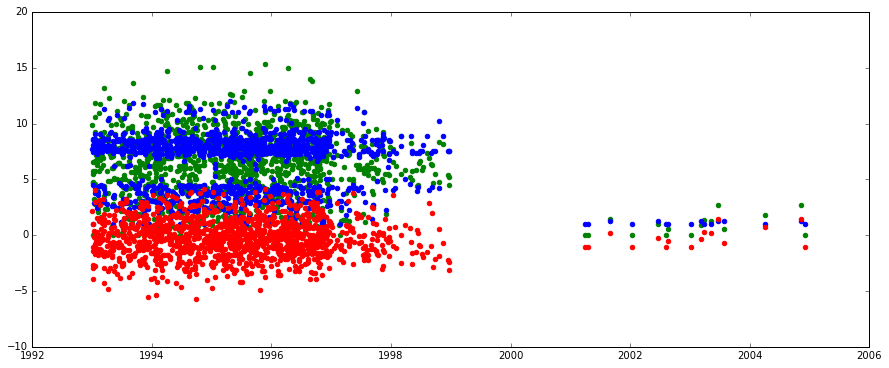

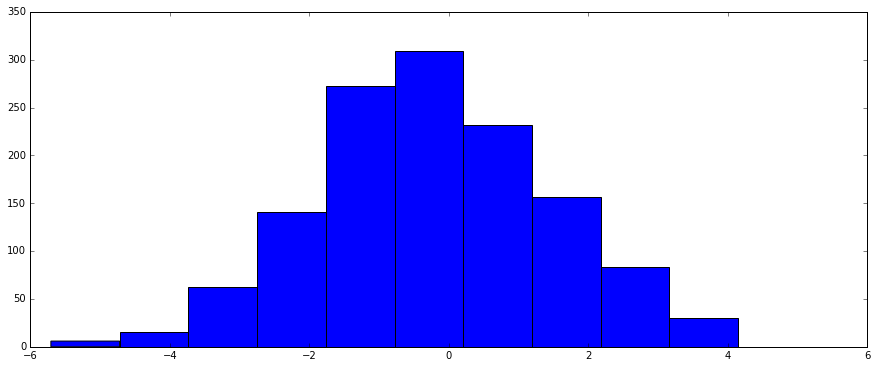

In [173]:
errorplot(clf2, xtest)

### These are pretty slow. Let's try random forests

In [60]:
num = [10, 50, 200, 500, 1000]
depth= [5,10, 12, 15, 20, 30, 40]
scores=np.empty([len(depth)+1, len(num)+1])
scores[0,1:] = num
scores[1:,0] = depth

In [61]:
for i in range(len(num)):
    for j in range(len(depth)):
        clf3 = ensemble.RandomForestRegressor(n_estimators=num[i], max_depth=depth[j])
        clf3.fit(xtrain, ytrain)
        rfscore=clf3.score(xtest, ytest)
        scores[j+1][i+1]=rfscore
print(scores)


[[    0.       10.       50.      200.      500.     1000.   ]
 [    5.        0.367     0.415     0.358     0.385     0.377]
 [   10.        0.281     0.419     0.373     0.373     0.369]
 [   12.        0.393     0.316     0.34      0.363     0.348]
 [   15.        0.329     0.373     0.358     0.352     0.36 ]
 [   20.        0.26      0.352     0.389     0.357     0.375]
 [   30.        0.389     0.389     0.388     0.376     0.347]
 [   40.        0.369     0.432     0.369     0.354     0.355]]


The scores are only slightly better than the linear model. 

In [47]:
num2 = [5, 10, 15, 20, 30, 40]
maxlf= [10, 50, 100, 200, 500]
scores2=np.empty([len(maxlf)+1, len(num2)+1])
scores2[0,1:] = num2
scores2[1:,0] = maxlf

In [48]:
for i in range(len(num2)):
    for j in range(len(maxlf)):
        clf3 = ensemble.RandomForestRegressor(n_estimators=num2[i], max_leaf_nodes=maxlf[j])
        clf3.fit(xtrain, ytrain)
        rfscore=clf3.score(xtest, ytest)
        scores2[j+1][i+1]=rfscore
print(scores2)

[[   0.       5.      10.      15.      20.      30.      40.   ]
 [  10.       0.594    0.419    0.424    0.503    0.471    0.463]
 [  50.       0.381    0.382    0.415    0.455    0.391    0.427]
 [ 100.       0.393    0.483    0.335    0.409    0.377    0.408]
 [ 200.       0.376    0.195    0.328    0.384    0.322    0.437]
 [ 500.       0.644    0.427    0.459    0.364    0.361    0.291]]


In [45]:
clf4 = ensemble.RandomForestRegressor(n_estimators=11, max_leaf_nodes=100)
clf4.fit(xtrain, ytrain)
rfscore2=clf4.score(xtest, ytest)
print(rfscore2)

0.382075664576


In [42]:
coefplot(clf4.feature_importances_)

NameError: name 'clf4' is not defined

In [92]:
errorplot(clf4, xtest)

TypeError: 'method' object is not subscriptable

In [93]:
lolo = LeaveOneLabelOut(train['cluster1'])
cvscores = cross_val_score(clf4, xtrain, ytrain, cv = lolo)
print(cvscores)


[ 0.796  0.875  0.116  0.865  0.656  0.768 -0.186]


(6092,)
(6092,)


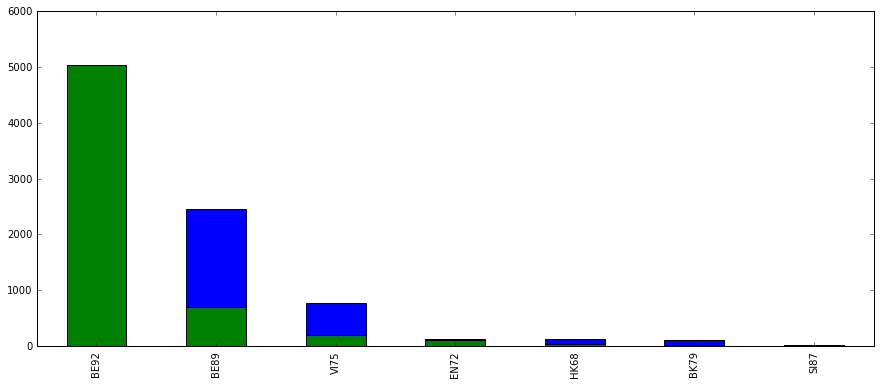

In [109]:
train.cluster1.value_counts().plot(kind='bar', color = 'b')
train.cluster2.value_counts().plot(kind='bar', color = 'g')
print(train.cluster1.shape)
print(train.cluster2.shape)

In [96]:
customcvscores = cross_val_score(clf4, xtrain, ytrain, cv = cvlist)
print(customcvscores)

[ 0.691  0.457  0.    -3.906 -3.413  0.    -0.305]


In [48]:
scores3=np.empty([7,6])
cvar = [0.01, 0.1, 1, 10, 100]
epsilonvar= [0.001, 0.01, 0.1, 1, 10, 100]
scores3[0,1:] = cvar
scores3[1:,0] = epsilonvar

In [49]:
for i in range(5):
    for j in range(6):
        clf5 = svm.SVR(C = cvar[i], epsilon = epsilonvar[j])
        clf5.fit(xtrain, ytrain)
        svmscore=clf5.score(xtest, ytest)
        scores3[j+1][i+1]=svmscore
print(scores3)

In [22]:
scores4=np.empty([7,6])
cvar = [0.5, 1, 2, 4, 10]
epsilonvar= [0.001, 0.01, 0.1, 0.5, 1, 2]
scores4[0,1:] = cvar
scores4[1:,0] = epsilonvar

for i in range(5):
    for j in range(6):
        clf5 = svm.SVR(C = cvar[i], epsilon = epsilonvar[j])
        clf5.fit(xtrain, ytrain)
        svmscore=clf5.score(xtest, ytest)
        scores4[j+1][i+1]=svmscore
print(scores4)

In [23]:
with open('svm scores grid 2', 'w') as f:
    f.write(repr(scores4))

In [26]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

print(scores4)

In [28]:
scores5=np.empty([6,3])
cvar = [0.5,10]
epsilonvar= [0.5, 0.8, 1, 1.2, 1.4]
scores5[0,1:] = cvar
scores5[1:,0] = epsilonvar

for i in range(2):
    for j in range(5):
        clf5 = svm.SVR(C = cvar[i], epsilon = epsilonvar[j])
        clf5.fit(xtrain, ytrain)
        svmscore=clf5.score(xtest, ytest)
        scores5[j+1][i+1]=svmscore
print(scores5)

In [1]:
with open('svm scores grid 3', 'w') as f:
    f.write(repr(scores5))

NameError: name 'scores5' is not defined

In [126]:

n_estimators = [5, 10, 20, 25, 30, 35]
learnrate= [0.01, 0.1, 1, 10, 15, 20, 40]
ABscores=np.empty([len(learnrate)+1, len(n_estimators)+1])
ABscores[0,1:] = n_estimators
ABscores[1:,0] = learnrate


for j in range(len(n_estimators)-1):
    for i in range(len(learnrate)-1):
        ABclf = sk.ensemble.AdaBoostRegressor(n_estimators=n_estimators[i], learning_rate=learnrate[j])
        ABclf.fit(xtrain, ytrain)
        ABscores[i+1,j+1] = ABclf.score(xtest, ytest)
        
print(ABscores)


[[  0.      5.     10.     20.     25.     30.     35.   ]
 [  0.01    0.643   0.292   0.548  -2.534  -2.015   0.   ]
 [  0.1     0.439   0.46    0.574  -0.943  -1.089   0.   ]
 [  1.      0.446   0.639   0.656  -1.812  -0.849   0.   ]
 [ 10.      0.445   0.637   0.64   -0.364   0.009   0.   ]
 [ 15.      0.451   0.533   0.643  -1.374   0.352   0.   ]
 [ 20.      0.446   0.643   0.652  -2.232  -2.025   0.   ]
 [ 40.      0.      0.      0.      0.      0.      0.   ]]


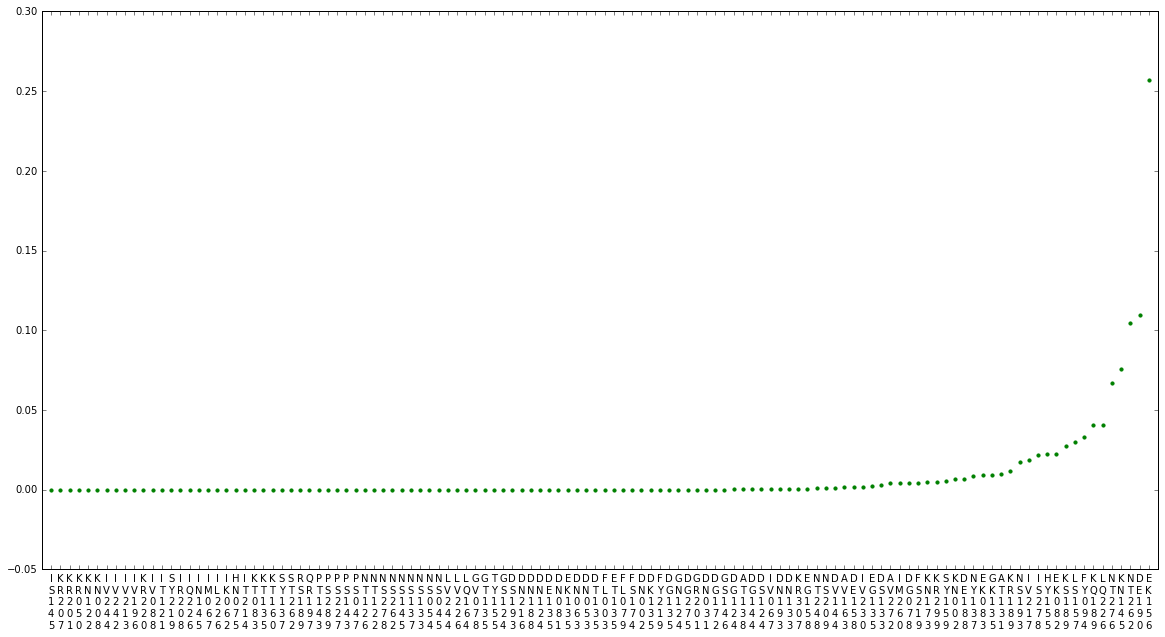

In [124]:
coefplot(ABclf.feature_importances_)

In [121]:
xtrain.shape

(6092, 120)

In [293]:
# Grid search with 10-fold cross-validation using a dictionary of parameters

# Create the dictionary of given parameters
n_estimators = [5, 10, 20, 40, 80]
learnrate= [0.01, 0.1, 1, 10]
parameters  = [{'n_estimators': n_estimators, 'learnrate': learnrate}] 

# Optimise and build the model with GridSearchCV
gridCV = grid_search.GridSearchCV(ensemble.AdaBoostRegressor, parameters, cv=cvlist)
gridCV.fit(xtrain, ytrain) 

# Report the optimal parameters
bestNeighbors = gridCV.best_params_['n_estimators']
bestWeight    = gridCV.best_params_['learnrate']

print("Best parameters: n_estimators=", bestNeighbors, "and learnrate=", bestWeight)


TypeError: get_params() missing 1 required positional argument: 'self'